[CareerVillage](http://www.careervillage.org) is a question-and-answer website where underserved youth (usually high school and college students) can ask questions about college and careers, and have their questions answered by professionals in their field of interest.  It's like [StackOverflow](http://stackoverflow.com) for students with career-related questions!  The site is fantastic because it provides a platform for underserved students to get advice about careers and college, when they otherwise would not have access to guidance councelors, professionals, or any sort of network from which to ask these important questions.

Currently, Career Village recommends questions to professionals primarily based on what tags students have used to label their questions, and what tags each professional subscribes to.  In order to make professionals aware of the questions which best match their expertise, Career Village is looking to improve the way they recommend questions to professionals, and make better use of the data they have which goes beyond simple tags.  They recently hosted a [Kaggle competition](http://www.kaggle.com/c/data-science-for-good-careervillage) to come up with a better recommendation system.

Here we'll develop an implicit content-based filtering system for recommending questions to professionals.  Given a question-professional pair, our model will predict how likely the professional is to answer the question.  This model can then be used to determine what new (or still-unanswered) questions a professional is most likely to answer, and those questions can be sent to the professional  either via email or via their landing page on the CareerVillage site.

The model will go beyond using only tag similarity information, and also extract information from the body of the question text, the question title, as well as information about the student which asked the question and the professional who may (hopfully) be able to answer it.  We'll be using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup) and [nltk](https://www.nltk.org) for processing the text data, [bert-as-service](https://github.com/hanxiao/bert-as-service) to create sentence and paragraph embeddings using a pre-trained [BERT language model](https://github.com/google-research/bert), and [XGBoost](https://github.com/dmlc/xgboost) to generate predictions as to how likely professionals are to answer student questions.

**Outline**
- [Loading the data](#loading-the-data)
- [Merge tags to questions, students, and professionals](#merge-tags-to-questions-students-and-professionals)
- [BERT Embeddings of the questions](#bert-embeddings-of-the-questions)
- [Compute average embedding of questions each professional has answered](#compute-average-embedding-of-questions-each-professional-has-answered)
- [Sample questions which each professional has not answered](#sample-questions-which-each-professional-has-not-answered)
- [Cosine similarity between question embeddings and average embedding for questions professionals have answered](#cosine-similarity-between-question-embeddings-and-average-embedding-for-questions-professionals-have-answered)
- [Extract date and time features](#extract-date-and-time-features)
- [Jaccard similarity between question and professional tags](#jaccard-similarity-between-question-and-professional-tags)
- [Train model to predict probability of answering](#train-model-to-predict-probability-of-answering)
- [Conclusion](#conclusion)

First let's load the packages we'll use:

In [1]:
import subprocess
import re
import os

# SciPy stack
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# XGBoost
from xgboost import XGBClassifier

# NLP
import html as ihtml
from bs4 import BeautifulSoup
from nltk import tokenize
from scipy.sparse import coo_matrix

# Plot settings
%config InlineBackend.figure_format = 'svg'
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Target encoder and other utilities
!pip install git+http://github.com/brendanhasz/dsutils.git
from dsutils.encoding import TargetEncoderCV
from dsutils.evaluation import metric_cv
from dsutils.evaluation import permutation_importance_cv
from dsutils.evaluation import plot_permutation_importance

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-usub9_iz
  Stored in directory: /tmp/pip-ephem-wheel-cache-0g6v_03h/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# BERT-as-service
!pip install bert-serving-server
!pip install bert-serving-client

    100% |████████████████████████████████| 61kB 7.1MB/s 
    100% |████████████████████████████████| 1.1MB 20.2MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
  Found existing installation: pyzmq 17.0.0
    Uninstalling pyzmq-17.0.0:
      Successfully uninstalled pyzmq-17.0.0
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Loading the data

The dataset consists of a set of data tables - 15 tables in all, but we're only going to use a few in this project.  There's a table which contains information about each student who has an account on CareerVillage, another table with information about each professional with an account on the site, another table with each question that's been asked on the site, etc.

The diagram below shows each table we'll use, and how values in columns in those tables relate to each other.  For example, we can figure out what student asked a given question by looking up where the value in the `questions_author_id` column of the `questions.csv` table occurs in the `students_id` column of the `students.csv` table.  Note that there's a lot of other information (columns) in the tables - in the diagram I've left out columns which don't contain relationships to other tables for clarity.

![Table Relationships](http://drive.google.com/uc?export=view&id=1qSBwFisuYIBBVg3LdIizoE5uLqiIiB2S)

In order to use a machine learning algorithm to predict how likely professionals are to answer questions, we'll need to transform this set of tables into a single large matrix.  Each row will correspond to a potential question-professional pair, and each column will correspond to a feature about that pair.  Features could include how similar the question text is to questions the professional has previously answered, how similar the question's tags are to the professional's tags, the date when the question was added, the date when the professional joined, etc.  A final column of the matrix will be our target variable: whether this question-professional pair actually occurred.  That is, whether the professional actually answered the question (in which case the value in the column will be 1), or not (0).

![Prepared Matrix](http://drive.google.com/uc?export=view&id=1DKMSQybx3b3Rz87wt0A6a9sLKXLhtrfX)

Once we've joined all our tables into this single large matrix, and engineered some additional features, we'll be able to use a machine learning algorithm to predict the likelihood that a professional would answer a given question, and then we can recommend the questions to that professional which have the highest predicted answer probability.

But first we need to load the data!

In [4]:
# Load tables
files = ['questions',
         'answers',
         'students',
         'professionals',
         'tag_questions',
         'tag_users',
         'tags']
dfs = dict()
for file in files:
    dfs[file] = pd.read_csv('../input/'+file+'.csv', dtype=str)

# Convert date cols to datetime
datetime_cols = {
    'answers': 'answers_date_added',
    'professionals': 'professionals_date_joined',
    'questions': 'questions_date_added',
    'students': 'students_date_joined',
}
for df, col in datetime_cols.items():
    dfs[df][col] = pd.to_datetime(dfs[df][col].str.slice(0, 19),
                                  format='%Y-%m-%d %H:%M:%S')

Let's take a quick look at a few rows from each data table to get a feel for the data contained in each.  The `questions.csv` table contains information about each question that is asked on the CareerVillage site, including the question text, the title of the question post, when it was posted, and what student posted it.

In [5]:
dfs['questions'].head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,Teacher career question,What is a maths teacher? what is a ma...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,To become a specialist in business management...,i hear business management is a hard way to ge...
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...


The `answers.csv` table stores information about professionals' answers to the questions which were posted, including the answer text, when the answer was posted, and what professional posted it.

In [6]:
dfs['answers'].head()

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14,<p>Hi!</p>\n<p>You are asking a very interesti...
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08,<p>Hi. I joined the Army after I attended coll...
2,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02,"<p>Dear Priyanka,</p><p>Greetings! I have answ..."
3,1a6b3749d391486c9e371fbd1e605014,7e72a630c303442ba92ff00e8ea451df,4ec31632938a40b98909416bdd0decff,2017-05-10 19:00:47,<p>I work for a global company who values high...
4,5229c514000446d582050f89ebd4e184,17802d94699140b0a0d2995f30c034c6,2f6a9a99d9b24e5baa50d40d0ba50a75,2017-10-13 22:07:33,I agree with Denise. Every single job I've had...


The `students.csv` table stores an ID for each student (which we'll use to identify each unique student in the other tables), the student's location (most of which are empty), and the date the student joined the CareerVillage site.

In [7]:
dfs['students'].head()

,students_id,students_location,students_date_joined
0,12a89e96755a4dba83ff03e03043d9c0,NaN,2011-12-16 14:19:24
1,e37a5990fe354c60be5e87376b08d5e3,NaN,2011-12-27 03:02:44
2,12b402cceeda43dcb6e12ef9f2d221ea,NaN,2012-01-01 05:00:00
3,a0f431fc79794edcb104f68ce55ab897,NaN,2012-01-01 05:00:00
4,23aea4702d804bd88d1e9fb28074a1b4,NaN,2012-01-01 05:00:00


Similarly, the `professionals.csv` table contains information about each professional who has a CareerVillage account, including their ID, location, industry, and the date they joined the site.

In [8]:
dfs['professionals'].head()

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,2011-10-05 20:35:19
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,2011-10-05 20:49:21
2,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",NaN,NaN,2011-10-18 17:31:26
3,977428d851b24183b223be0eb8619a8c,"Boston, Massachusetts",NaN,NaN,2011-11-09 20:39:29
4,e2d57e5041a44f489288397c9904c2b2,NaN,NaN,NaN,2011-12-10 22:14:44


The remaining three tables store information about tags.  When students post questions, they can tag their questions with keywords to help professionals find them.  Sudents can also set tags for themselves (to indicate what fields they're interested in, for example `nursing`, or what topics they are needing help with, for example `college-admission`).  Professionals can subscribe to tags, and they'll get notifications of questions which have the tags they suscribe to.

The `tag_questions.csv` table has a list of tag ID - question ID pairs.  This will allow us to figure out what tags each question has: for each question, we can look up rows in `tag_questions` where the question ID matches that question. 

In [9]:
dfs['tag_questions'].head()

,tag_questions_tag_id,tag_questions_question_id
0,28930,cb43ebee01364c68ac61d347a393ae39
1,28930,47f55e85ce944242a5a347ab85a8ffb4
2,28930,ccc30a033a0f4dfdb2eb987012f25792
3,28930,e30b274e48d741f7bf50eb5e7171a3c0
4,28930,3d22742052df4989b311b4195cbb0f1a


Similarly, `tag_users.csv` has a list of tag ID - user ID pairs, which we can use to figure out what tags each student has, or what tags each professional subscribes to.

In [10]:
dfs['tag_users'].head()

,tag_users_tag_id,tag_users_user_id
0,593,c72ab38e073246e88da7e9a4ec7a4472
1,1642,8db519781ec24f2e8bdc67c2ac53f614
2,638,042d2184ee3e4e548fc3589baaa69caf
3,11093,c660bd0dc1b34224be78a58aa5a84a63
4,21539,8ce1dca4e94240239e4385ed22ef43ce


Notice that the tag IDs in the previous two tables aren't the text of the tag, they're just an arbitrary integer.  In order to figure out what actual tags (that is, the tag text) each question, student, or professional has, we'll need to use the `tags.csv` table, which contains the tag text for each tag ID.

In [11]:
dfs['tags'].head()

,tags_tag_id,tags_tag_name
0,27490,college
1,461,computer-science
2,593,computer-software
3,27292,business
4,18217,doctor


Now that we've loaded the data, we can start linking up the tables to construct the single large matrix we'll need to perform prediction.

## Merge tags to questions, students, and professionals

First we'll join the tags information to the questions, students, and professionals tables, so that we have a list of tags for each question, student, and professional.

Unfortunately the tag text is a bit inconsistent: some tags have the hashtag character (`#`) before the tag text, and some don't.  We can remove hashtag characters to ensure that all the tag data contains just text:

In [12]:
def remove_hashtags(text):
    if type(text) is float:
        return ''
    else:
        return re.sub(r"#", "", text)
    
# Remove hashtag characters
dfs['tags']['tags_tag_name'] = \
    dfs['tags']['tags_tag_name'].apply(remove_hashtags)

Now we can add a list of tags to each question in the questions table.  We'll make a function which creates a list of tags for each user/question, then merge the tag text to the questions table.

![Join tags to questions](http://drive.google.com/uc?export=view&id=1FDMTg-kTtXBm4lZWfrE4PGE8bWnrywIC)


In [13]:
def agg_tags(df_short, df_long, short_col, long_col, long_col_agg):
    """Aggregate elements in a shorter df by joining w/ spaces"""
    grouped = df_long.groupby(long_col)
    joined_tags = grouped.agg({long_col_agg: lambda x: ' '.join(x)})
    out_df = pd.DataFrame(index=list(df_short[short_col]))
    out_df['aggs'] = joined_tags
    return list(out_df['aggs'])

# Merge tags to questions
tag_questions = dfs['tag_questions'].merge(dfs['tags'],
                                           left_on='tag_questions_tag_id',
                                           right_on='tags_tag_id')
questions = dfs['questions']
questions['questions_tags'] = \
    agg_tags(questions, tag_questions,
             'questions_id', 'tag_questions_question_id', 'tags_tag_name')

Then we can add a list of tags to each professional and student.  First we'll join the tag text to the `tag_users` table, and then add a list of tags for each student and professional to their respective tables.

![Join tags to students and professionals](http://drive.google.com/uc?export=view&id=1DQdij2Piof-NAE1q3MHjmBvdGyqrrIou)

In [14]:
# Merge tag text to tags_users
tag_users = dfs['tag_users'].merge(dfs['tags'], 
                                   left_on='tag_users_tag_id',
                                   right_on='tags_tag_id')

# Merge tags to students
students = dfs['students']
students['students_tags'] = \
    agg_tags(students, tag_users, 
             'students_id', 'tag_users_user_id', 'tags_tag_name')

# Merge tags to professionals
professionals = dfs['professionals']
professionals['professionals_tags'] = \
    agg_tags(professionals, tag_users, 
             'professionals_id', 'tag_users_user_id', 'tags_tag_name')

Now the questions, students, and professionals tables contain columns with space-separated lists of their tags.

## BERT embeddings of the questions

For our predictive algorithm to use information about the question text, we'll have to convert the text information into numeric values.  To capture information about the content of the question text, we'll use a pre-trained BERT model to generate embeddings of the text of each question.  BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a deep neural network model which uses layers of attention networks ([Transformers](https://arxiv.org/abs/1706.03762)) to model the next word in a sentence or paragraph given the preceeding words.  We'll take a pre-trained BERT model, pass it the text of the questions, and then use the activations of a layer near the end of the network as our features.  These features (the "encodings" or "embeddings", which I'll use interchangeably) should capture information about the content of the question, while encoding the question text into a vector of a fixed length, which our prediction algorithm requires!

[Han Xiao](http://hanxiao.github.io/) has a great package called [bert-as-service](http://github.com/hanxiao/bert-as-service) which can generate embeddings using a pre-trained BERT model (fun fact: they're also one of the people behind [fashion MNIST](http://github.com/zalandoresearch/fashion-mnist)).  Basically the package runs a BERT model on a server, and one can send that server requests (consisting of sentences) to generate embeddings of those sentences.

Note that another valid method for generating numeric representations of text would be to use latent Dirichlet allocation (LDA) topic modelling.  We could treat each question as a bag of words, use LDA to model the topics, and then use the estimated topic probability distribution for each question as our "embedding" for that question.  Honestly using LDA might even be a better way to capture information about the question content, because we're mostly interested in the *topic* of the question (which LDA exclusively models), rather than the semantic content (which BERT also models).

### Clean the sentences

Before embedding the question title and body text, we'll first have to clean that data.  Let's remove weird whitespace characters, HTML tags, and other things using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).

Some students also included hashtags directly in the question body text.  We'll just remove the hashtag characters from the text.  A different option would be to pull out words after hashtags and add them to the tag list for the question, and then remove them from the question text.   But for now we'll just remove the hashtag character and keep the tag text in the question body text.

In [15]:
# Pull out a list of question text and titles
questions_list = list(questions['questions_body'])
question_title_list = list(questions['questions_title'])

In [16]:
def clean_text(text):
    if type(text) is float:
        return ' '
    text = BeautifulSoup(ihtml.unescape(text), "html.parser").text
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"#", "", text) #just remove hashtag character
    return text

In [17]:
# Clean the questions text and titles
questions_list = [clean_text(s) for s in questions_list]
question_title_list = [clean_text(s) for s in question_title_list]

Because BERT can only encode a single sentence at a time, we also need to ensure each question is a list of strings, where each sentence is a string, and each list corresponds to a single question (so we'll have a list of lists of strings).  So, let's use [nltk](https://www.nltk.org/)'s [sent_tokenize](https://www.nltk.org/api/nltk.tokenize.html) to separate the questions into lists of sentences.

In [18]:
# Convert questions to lists of sentences
questions_list = [tokenize.sent_tokenize(s) for s in questions_list]

### Start the BERT server

To use bert-as-service to generate features, we'll first have to download the model, start the server, and then start the client service which we'll use to request the sentence encodings.

In [19]:
# Download and unzip the model
!wget http://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2019-05-20 02:23:14--  http://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  50.3MB/s    in 8.0s    

2019-05-20 02:23:22 (48.4 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [20]:
# Start the BERT server
bert_command = 'bert-serving-start -model_dir /kaggle/working/uncased_L-12_H-768_A-12'
process = subprocess.Popen(bert_command.split(), stdout=subprocess.PIPE)

In [21]:
# Start the BERT client
from bert_serving.client import BertClient

In [22]:
bc = BertClient()

Now that we've started up the client and the server, we can use bert-as-service to embed some sentences!

In [23]:
encodings = bc.encode(['an example sentence',
                       'a different example sentence'])

The output encoding is a vector with 768 elements for each sentence:

In [24]:
encodings.shape

(2, 768)

### Embed the question titles with BERT

Each title we'll treat as a single sentence, so we can use bert-as-service to encode the titles really easily:

In [25]:
%%time
question_title_embeddings = bc.encode(question_title_list)

/opt/conda/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 28 ms, sys: 92 ms, total: 120 ms
Wall time: 18.8 s


Now we have 768-dimensional embeddings for each title of our ~24k questions.

In [26]:
question_title_embeddings.shape

(23931, 768)

### Compute average embedding of each sentence in questions

Most of the time, the questions' body text contain multiple sentences - but the BERT models we're using were only trained on single sentences.  To generate an encoding of the entire paragraph for each question, we'll use BERT to encode each sentence in that question, and then take the average of their encodings.

In [27]:
def bert_embed_paragraphs(paragraphs):
    """Embed paragraphs by taking the average embedding of each sentence
    
    Parameters
    ----------
    paragraphs : list of lists of str
        The paragraphs.  Each element should correspond to a paragraph
        and each paragraph should be a list of str, where each str is 
        a sentence.
    
    Returns
    -------
    embeddings : numpy ndarray of size (len(paragraphs), 768)
        The paragraph embeddings
    """
    
    # Covert to single list
    # (this is b/c bert-as-service is faster w/ one large request
    # than with many small requests)
    sentences = []
    ids = []
    for i in range(len(paragraphs)):
        sentences += paragraphs[i]
        ids += [i]*len(paragraphs[i])
        
    # Embed the sentences
    embeddings = bc.encode(sentences)
    
    # Average by paragraph id
    Np = len(paragraphs) #number of paragraphs
    n_dims = embeddings.shape[1]
    embeddings_out = np.full([Np, n_dims], np.nan)
    ids = np.array(ids)
    the_range = np.arange(len(ids))
    for i in range(n_dims):
        embeddings_out[:,i] = coo_matrix((embeddings[:,i], (ids, the_range))).mean(axis=1).ravel()
    return embeddings_out

In [28]:
%%time

# Embed the questions
questions_embeddings = bert_embed_paragraphs(questions_list)

/opt/conda/lib/python3.6/site-packages/bert_serving/client/__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


CPU times: user 2.57 s, sys: 348 ms, total: 2.92 s
Wall time: 55.8 s


### Reduce dimensionality of the embeddings using PCA

The embeddings have a pretty large dimensionality for the amount of data we have.  To reduce the number of dimensions while keeping the most useful information, we'll perform dimensionality reduction using principal components analysis (PCA).  We'll just take the top 10 dimensions which explain the most variance of the embeddings.

In [29]:
%%time

# Reduce BERT embedding dimensionality w/ PCA
pca = PCA(n_components=10)
question_title_embeddings = pca.fit_transform(question_title_embeddings)
questions_embeddings = pca.fit_transform(questions_embeddings)

CPU times: user 3.49 s, sys: 968 ms, total: 4.46 s
Wall time: 2.52 s


### Add embeddings to tables

Now that we have matrixes corresponding to the title and question encodings, we need to replace the question body text in our original table with the encoding values we generated.

In [30]:
# Drop the text data
questions.drop('questions_title', axis='columns', inplace=True)
questions.drop('questions_body', axis='columns', inplace=True)
answers = dfs['answers']
answers.drop('answers_body', axis='columns', inplace=True)

def add_matrix_to_df(df, X, col_name):
    for iC in range(X.shape[1]):
        df[col_name+str(iC)] = X[:,iC]
        
# Add embeddings data
add_matrix_to_df(questions, questions_embeddings, 'questions_embeddings')
add_matrix_to_df(questions, question_title_embeddings, 'question_title_embeddings')

Instead of containing the raw text of the question, our `questions` table now contains the 10-dimensional embeddings of the questions and the question titles.

In [31]:
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_tags,questions_embeddings0,questions_embeddings1,questions_embeddings2,questions_embeddings3,questions_embeddings4,questions_embeddings5,questions_embeddings6,questions_embeddings7,questions_embeddings8,questions_embeddings9,question_title_embeddings0,question_title_embeddings1,question_title_embeddings2,question_title_embeddings3,question_title_embeddings4,question_title_embeddings5,question_title_embeddings6,question_title_embeddings7,question_title_embeddings8,question_title_embeddings9
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,lecture college professor,-0.000004,0.000098,0.000068,-0.000009,-0.000005,0.000013,0.000016,3.585137e-05,-0.000055,-0.000016,-1.496018,2.906482,0.742657,2.613477,0.594892,-0.409248,0.906179,-0.660361,0.287215,3.032586
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,military army,0.000195,-0.000026,0.000013,0.000076,0.000080,0.000105,0.000056,-2.081525e-05,-0.000046,0.000043,1.851437,-1.149743,1.804537,-2.325670,2.219611,0.333576,-0.367904,-0.087492,-0.011894,-0.200671
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,overseas working-abroad,0.000483,-0.000054,-0.000027,0.000050,-0.000029,-0.000065,0.000025,-5.631966e-05,0.000028,0.000028,2.022816,-0.107412,-1.130666,0.345844,-1.134659,-2.309236,0.514931,-0.743425,1.074617,-0.946497
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,networking business,-0.000154,0.000030,-0.000010,-0.000031,-0.000010,-0.000031,-0.000013,-3.469811e-07,0.000027,-0.000005,1.385680,-0.560528,0.689630,-0.082240,1.406173,0.333430,1.572107,-0.244382,-0.983686,0.118426
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,scholarships highschoolsenior college firstgen...,-0.000103,-0.000014,0.000017,0.000020,-0.000044,0.000044,0.000009,1.836574e-05,0.000007,-0.000010,0.344961,2.765032,-0.296200,0.555621,-0.609315,-1.631425,-1.082986,-0.601191,0.616390,-1.673865


## Compute average embedding of questions each professional has answered

An important predictor of whether a professional will answer a question is likely how similar that question is to ones they have answered in the past.  To create a feature which measures how similar a question is to ones a given professional has answered, we'll compute the average embedding of questions each professional has answered.  Then later, we'll add a feature which measures the distance between a question's embedding and professional's average embedding.

However, to connect the questions to the professionals, we'll first have to merge the questions to the answers table, and then merge the result to the professionals table.

In [32]:
# Merge questions and answers
answer_questions = answers.merge(questions, 
                                 left_on='answers_question_id',
                                 right_on='questions_id')

# Merge answers and professionals
professionals_questions = answer_questions.merge(professionals, how='left',
                                                 left_on='answers_author_id',
                                                 right_on='professionals_id')

Then we can compute the average question embedding for all questions each professional has answered.

In [33]:
# Compute mean question embedding of all Qs each professional has answered
aggs = dict((c, 'mean') for c in professionals_questions if 'questions_embeddings' in c)
mean_prof_q_embeddings = (professionals_questions
                          .groupby('professionals_id')
                          .agg(aggs))
mean_prof_q_embeddings.columns = ['mean_'+x for x in mean_prof_q_embeddings.columns]
mean_prof_q_embeddings.reset_index(inplace=True)

# Add mean Qs embeddings to professionals table
professionals = professionals.merge(mean_prof_q_embeddings,
                                    how='left', on='professionals_id')

And we'll do the same thing for the question titles:

In [34]:
# Compute mean question title embedding of all Qs each professional has answered
aggs = dict((c, 'mean') for c in professionals_questions if 'question_title_embeddings' in c)
mean_q_title_embeddings = (professionals_questions
                          .groupby('professionals_id')
                          .agg(aggs))
mean_q_title_embeddings.columns = ['mean_'+x for x in mean_q_title_embeddings.columns]
mean_q_title_embeddings.reset_index(inplace=True)

# Add mean Qs embeddings to professionals table
professionals = professionals.merge(mean_q_title_embeddings,
                                    how='left', on='professionals_id')

## Sample questions which each professional has not answered

To train a model which predicts whether a professional will answer a given question or not, we'll need to construct a dataset containing examples of question-professional pairs which exist (that is, questions the professional has answered) and question-professional pairs which do *not* exist (questions the professional has *not* actually answered).  We obviously already have pairs which do exist (in the `answers` table), but we need to sample pairs which do not exist in order to have negative samples on which to train our model.  You can't train a model to predict A from B if you don't have any examples of B!  Coming up with these negative examples is called [negative sampling](https://arxiv.org/abs/1310.4546), and is often used in natural language processing (also see this great [video about it](https://www.coursera.org/lecture/nlp-sequence-models/negative-sampling-Iwx0e)).  Here we'll just create negative samples once, instead of once per training epoch.

Let's define a function which adds negative samples to a list of positive sample pairs:

In [35]:
def add_negative_samples(A, B, k=5):
    """Add pairs which do not exist to positive pairs.
    
    If `A` and `B` are two corresponding lists , this function
    returns a table with two copies of elements in `A`.
    For the first copy, corresponding elements in `B` are unchaged.
    However, for the second copy, elements in `B` are elements
    which exist in `B`, but the corresponding `A`-`B` pair
    does not exist in the original pairs.
    
    Parameters
    ----------
    A : list or ndarray or pandas Series
        Indexes
    B : list or ndarray or pandas Series
        Values
    k : int
        Number of negative samples per positive sample.
        Default=5
    
    Returns
    -------
    Ao : list
        Output indexes w/ both positive and negative samples.
    Bo : list
        Output indexes w/ both positive and negative samples.
    E : list
        Whether the corresponding `Ao`-`Bo` pair exists (1) or
        does not (0) in the original input data.
    """
    
    # Convert to lists
    if isinstance(A, (np.ndarray, pd.Series)):
        A = A.tolist()
    if isinstance(B, (np.ndarray, pd.Series)):
        B = B.tolist()
    
    # Construct a dict of pairs for each unique value in A
    df = pd.DataFrame()
    df['A'] = A
    df['B'] = B
    to_sets = lambda g: set(g.values.tolist())
    pairs = df.groupby('A')['B'].apply(to_sets).to_dict()
    
    # Randomize B
    uB = np.unique(B) # unique elements of B
    nB = np.random.choice(uB, k*len(A)).tolist() #(hopefully) negative samples
        
    # Ensure pairs do not exist
    for i in range(k*len(A)):
        while nB[i] in pairs[A[i%len(A)]]:
            nB[i] = np.random.choice(uB)
            # NOTE: this will run forever if there's an element 
            # in A which has pairs w/ *all* unique values of B...
            
    # Construct output lists
    Ao = A*(k+1)
    Bo = B+nB
    E = [1]*len(A) + [0]*(k*len(A))
    return Ao, Bo, E

Now we can create a table which contains professional-question pairs which exist, and the same number of pairs for each professional which do *not* exist:

In [36]:
# Find negative samples
author_id_samples, question_id_samples, samples_exist = \
    add_negative_samples(answers['answers_author_id'], 
                         answers['answers_question_id'])

# Create table containing both positive and negative samples
train_df = pd.DataFrame()
train_df['target'] = samples_exist
train_df['professionals_id'] = author_id_samples
train_df['questions_id'] = question_id_samples

Finally, for each answer-question pair, we can add information about the professional who authored it (or did not author it), the question which it answered, and the student who asked that question.

In [37]:
# Merge with professionals table
train_df = train_df.merge(professionals, how='left',
                          on='professionals_id')

# Merge with questions table
train_df = train_df.merge(questions, how='left',
                          on='questions_id')

# Merge with students table
train_df = train_df.merge(students, how='left',
                          left_on='questions_author_id',
                          right_on='students_id')

# Delete extra columns that won't be used for prediction
del train_df['professionals_id']
del train_df['questions_id']
del train_df['professionals_headline'] #though this could definitely be used...
del train_df['questions_author_id']
del train_df['students_id']

## Cosine similarity between question embeddings and average embedding for questions professionals have answered

Professionals are probably more likely to answer questions which are similar to ones they've answered before.  To capture how similar the text of a question is to questions a professional has previously answered, we can measure how close the question's BERT embedding is the the average of the embeddings of questions the professional has answered.

To measure this "closeness", we'll use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).  Cosine similarity measures the cosine of the angle between two points.  When the angle is near 0, the cosine similarity is near 1, and when the angle between the two points is as large as it can be (near 180), the cosine similarity is -1.  Given two embedding vectors $\mathbf{a}$ and $\mathbf{b}$, the cosine distance is:

$$
\frac{\mathbf{a}^\top \mathbf{b}}{||\mathbf{a}|| ~ ||\mathbf{b}||}
$$

There are a few other ways we could have measured the similarity between the embeddings of previously answered questions and the embedding of a new question.  Instead of just taking the mean embedding we could also account for the *spread* of the embeddings by computing the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), which would account for the possibility that some professionals have broader expertise than others.  We could also use a model to predict whether the new question is in the set of questions the professional has answered (for example, K-nearest neighbors).  However, just computing the cosine distance from the mean embedding of previously answered questions will probably give nearly as good results, and will be hundreds of times faster to compute, so we'll do that here.

Let's create a function to compute the cosine similarity between pairs of columns in a dataframe:

In [38]:
def cosine_similarity_df(A, B):
    """Compute the cosine similarities between each row of two matrixes
    
    Parameters
    ----------
    A : numpy matrix or pandas DataFrame
        First matrix.
    B : numpy matrix or pandas DataFrame
        Second matrix.  Must be same size as A.
    
    Returns
    -------
    cos_sim : numpy ndarray of shape (A.shape[0],)
    """
    
    # Convert to numpy arrays
    if isinstance(A, pd.DataFrame):
        A = A.values
    if isinstance(B, pd.DataFrame):
        B = B.values
            
    # Ensure both matrixes are same size
    if not A.shape == B.shape:
        raise ValueError('A and B must be same size')
        
    # Compute dot products
    dot_prods = np.sum(A*B, axis=1)
    
    # Compute magnitudes
    mA = np.sqrt(np.sum(np.square(A), axis=1))
    mB = np.sqrt(np.sum(np.square(B), axis=1))
    
    # Return cosine similarity between rows
    return dot_prods / (mA*mB)

Then we can use that function to compute the cosine similarities between each question embedding and the mean embedding of questions the professional has answered, and add it to our training dataframe (the one with both positive and negative samples, which we created in the previous section).  We'll also do the same for the embeddings of the question titles.

In [39]:
# Compute similarity between professional's mean Q embedding and Q embedding
mean_question_embedding_cols = [c for c in train_df.columns 
                                if 'mean_questions_embeddings' in c]
question_embedding_cols = [c for c in train_df.columns 
                           if 'questions_embeddings' in c and 'mean' not in c]
train_df['question_embedding_similarity'] = \
    cosine_similarity_df(train_df[mean_question_embedding_cols],
                         train_df[question_embedding_cols])

# Compute similarity between professional's mean Q embedding and Q title embedding
mean_title_embedding_cols = [c for c in train_df.columns 
                             if 'mean_question_title_embeddings' in c]
title_embedding_cols = [c for c in train_df.columns 
                        if 'question_title_embeddings' in c and 'mean' not in c]
train_df['title_embedding_similarity'] = \
    cosine_similarity_df(train_df[mean_title_embedding_cols],
                         train_df[title_embedding_cols])

Do these similarity scores actually capture information about whether a professional is more likely to answer a question or not?  Let's plot a histogram of the similarity scores for questions which the professional has actually answered against those which they did not.  There's a respectable difference between the two distributions:

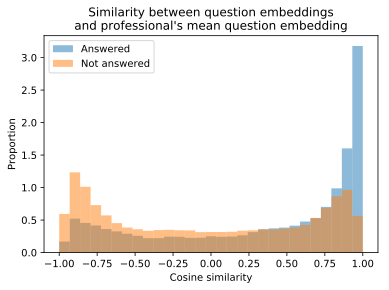

In [40]:
# Plot histograms of question embedding sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(-1, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'question_embedding_similarity'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'question_embedding_similarity'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.xlabel('Cosine similarity')
plt.ylabel('Proportion')
plt.title('Similarity between question embeddings\n'
          'and professional\'s mean question embedding')
plt.show()

There's an even larger difference when we plot the same thing for the title embedding similarity scores!

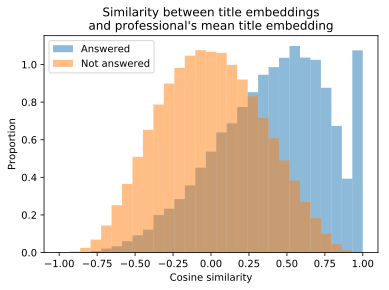

In [41]:
# Plot histograms of title embedding sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(-1, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'title_embedding_similarity'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'title_embedding_similarity'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.xlabel('Cosine similarity')
plt.ylabel('Proportion')
plt.title('Similarity between title embeddings\n'
          'and professional\'s mean title embedding')
plt.show()

Note that computing the mean embedding with *all* the data is introducing data leakage if we evaluate the model using cross validation.  For example, many of the cosine similarities are exactly 1.  This occurs when a professional has answered exactly one question (and so the similarity between the mean embedding of answered questions and the embedding of that question are equal!).  To properly evaluate the performance of our model, we would want to use a nested cross-validated scheme, where the training set includes only questions posted before some time point, and the test set includes only questions posted after that timepoint.  However, we could put the model into production as-is, as long as we only use it to predict answer likelihoods for questions that were asked after the model was trained.

## Extract date and time features

Date and time features could in theory be informative in predicting whether a professional will answer a given question.  For example, a professional may be far more likely to answer questions in a few months after they join the CareerVillage site, but may become less (or more!) enthusiastic over time and answer less (or more) questions.  Keep in mind that this may not be information we really want to consider when making recommendations.  It could be that we only want to be considering the content of the question and the expertise of the professional.  Let's include date and time features for now, as they're easily removable.

In [42]:
# Extract date and time features
train_df['students_joined_year']      = train_df['students_date_joined'].dt.year
train_df['students_joined_month']     = train_df['students_date_joined'].dt.month
train_df['students_joined_dayofweek'] = train_df['students_date_joined'].dt.dayofweek
train_df['students_joined_dayofyear'] = train_df['students_date_joined'].dt.dayofyear
train_df['students_joined_hour']      = train_df['students_date_joined'].dt.hour

train_df['questions_added_year']      = train_df['questions_date_added'].dt.year
train_df['questions_added_month']     = train_df['questions_date_added'].dt.month
train_df['questions_added_dayofweek'] = train_df['questions_date_added'].dt.dayofweek
train_df['questions_added_dayofyear'] = train_df['questions_date_added'].dt.dayofyear
train_df['questions_added_hour']      = train_df['questions_date_added'].dt.hour

train_df['professionals_joined_year']      = train_df['professionals_date_joined'].dt.year
train_df['professionals_joined_month']     = train_df['professionals_date_joined'].dt.month
train_df['professionals_joined_dayofweek'] = train_df['professionals_date_joined'].dt.dayofweek
train_df['professionals_joined_dayofyear'] = train_df['professionals_date_joined'].dt.dayofyear
train_df['professionals_joined_hour']      = train_df['professionals_date_joined'].dt.hour

# Remove original datetime columns
del train_df['students_date_joined']
del train_df['questions_date_added']
del train_df['professionals_date_joined']

## Jaccard similarity between question and professional tags

The original CareerVillage question recommendation system was based solely on tags.  While we've added a lot to that here, tags are still carry a lot of information about how likely a professional is to answer a question.  If a question has exactly the same tags as a professional subscribes to, of course that professional is more likely to answer the question!  To let our recommendation model decide how heavily to depend on the tag similarity, we'll add the similarity between a question's tags and a professional's tags as a feature.

Specifically, we'll use [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index), which measures how similar two sets are.  The Jaccard similarity is the number of elements (in our case, tags) in common between the two sets (between the question's and the professional's set  of tags), divided by the number of unique elements all together.

$$
J(A, B) = \frac{|A \cap B|}{| A \cup B |} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$

where $|x|$ is the number of elements in set $x$, $A \cup B$ is the union of sets $A$ and $B$ (all unique items after pooling both sets), and $A \cap\ B$ is the intersection of the two sets (only the items which are in *both* sets).  Python's built-in `set` data structure makes it pretty easy to compute this metric:

In [43]:
def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets"""
    set1 = set(set1)
    set2 = set(set2)
    union_len = len(set1.intersection(set2))
    return union_len / (len(set1) + len(set2) - union_len)

We'll also want a function to compute the Jaccard similarity between pairs of sets in a dataframe:

In [44]:
def jaccard_similarity_df(df, col1, col2, sep=' '):
    """Compute Jaccard similarity between lists of sets.
    
    Parameters
    ----------
    df : pandas DataFrame
        data
    col1 : str
        Column for set 1.  Each element should be a string, with space-separated elements
    col2 : str
        Column for set 2.
        
    Returns
    -------
    pandas Series
        Jaccard similarity for each row in df
    """
    list1 = list(df[col1])
    list2 = list(df[col2])
    scores = []
    for i in range(len(list1)):
        if type(list1[i]) is float or type(list2[i]) is float:
            scores.append(0.0)
        else:
            scores.append(jaccard_similarity(
                list1[i].split(sep), list2[i].split(sep)))
    return pd.Series(data=scores, index=df.index)

We can use that function to compute the Jaccard similarity between the tags for each professional and the question which they did (or didn't) answer, and add that information to our training dataframe.

In [45]:
# Compute jaccard similarity between professional and question tags
train_df['question_professional_tag_jac_sim'] = \
    jaccard_similarity_df(train_df, 'questions_tags', 'professionals_tags')

# Compute jaccard similarity between professional and student tags
train_df['student_professional_tag_jac_sim'] = \
    jaccard_similarity_df(train_df, 'students_tags', 'professionals_tags')

# Remove tag columns
del train_df['questions_tags']
del train_df['professionals_tags']
del train_df['students_tags']

Are professionals actually more likely to answer questions which have similar tags to the ones they subscribe to?  We can plot histograms comparing the Jaccard similarity between tags for professional-question pairs which were answered and those which weren't.  It looks like the tags are on average more similar for questions which a professional did actually answer, but this separation isn't quite as clear as it was for the question embeddings:

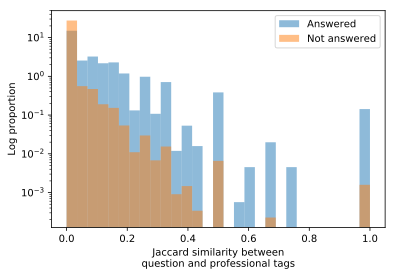

In [46]:
# Plot histograms of jac sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(0, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'question_professional_tag_jac_sim'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'question_professional_tag_jac_sim'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.yscale('log', nonposy='clip')
plt.xlabel('Jaccard similarity between\nquestion and professional tags')
plt.ylabel('Log proportion')
plt.show()

The students are also able to have tags (to indicate what fields they're interested in).  This might also be useful information for our recommender, seeing as students might not include all the relevant tags in a question post, but may still have the tag on their profile.  Again we can plot histograms for the Jaccard similarity scores for question-professional pairs which were answered and those which weren't.

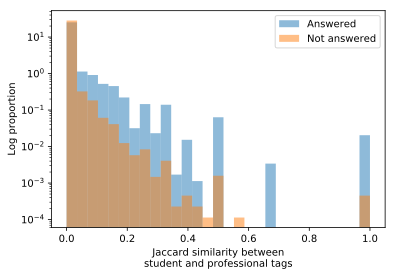

In [47]:
# Plot histograms of jac sim for Q-prof pairs
# which were answered and Q-prof pairs which weren't
bins = np.linspace(0, 1, 30)
answered = train_df['target']==1
plt.hist(train_df.loc[answered, 'student_professional_tag_jac_sim'],
         bins=bins, label='Answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[0])+(0.5,))
plt.hist(train_df.loc[~answered, 'student_professional_tag_jac_sim'],
         bins=bins, label='Not answered', density=True,
         fc=matplotlib.colors.to_rgb(COLORS[1])+(0.5,))
plt.legend()
plt.yscale('log', nonposy='clip')
plt.xlabel('Jaccard similarity between\nstudent and professional tags')
plt.ylabel('Log proportion')
plt.show()

## Train model to predict probability of answering

Now we finally have one large matrix where each row corresponds to a question-professional pair, and each column corresponds to features about that pair!  The `target` column contains whether that question was actually answered by the professional for that row, and the rest of the column contain features about the professional, the question, the student who asked it, and the interactions between them.  All the data is either numeric or categorical, and so we're ready to build a model which will use the features to predict the probability that a question will be answered by a professional.

In [48]:
train_df.head()

,target,professionals_location,professionals_industry,mean_questions_embeddings0,mean_questions_embeddings1,mean_questions_embeddings2,mean_questions_embeddings3,mean_questions_embeddings4,mean_questions_embeddings5,mean_questions_embeddings6,mean_questions_embeddings7,mean_questions_embeddings8,mean_questions_embeddings9,mean_question_title_embeddings0,mean_question_title_embeddings1,mean_question_title_embeddings2,mean_question_title_embeddings3,mean_question_title_embeddings4,mean_question_title_embeddings5,mean_question_title_embeddings6,mean_question_title_embeddings7,mean_question_title_embeddings8,mean_question_title_embeddings9,questions_embeddings0,questions_embeddings1,questions_embeddings2,questions_embeddings3,questions_embeddings4,questions_embeddings5,questions_embeddings6,questions_embeddings7,questions_embeddings8,questions_embeddings9,question_title_embeddings0,question_title_embeddings1,question_title_embeddings2,question_title_embeddings3,question_title_embeddings4,question_title_embeddings5,question_title_embeddings6,question_title_embeddings7,question_title_embeddings8,question_title_embeddings9,students_location,question_embedding_similarity,title_embedding_similarity,students_joined_year,students_joined_month,students_joined_dayofweek,students_joined_dayofyear,students_joined_hour,questions_added_year,questions_added_month,questions_added_dayofweek,questions_added_dayofyear,questions_added_hour,professionals_joined_year,professionals_joined_month,professionals_joined_dayofweek,professionals_joined_dayofyear,professionals_joined_hour,question_professional_tag_jac_sim,student_professional_tag_jac_sim
0,1,"Cleveland, Ohio",Mental Health Care,0.000049,-0.000004,0.000011,-0.000003,-1.106822e-05,1.138655e-06,-4.139757e-06,-0.000002,6.465761e-07,1.462932e-06,0.148946,-0.141256,-0.001260,0.112179,-0.236281,-0.041852,0.112263,0.097947,0.076181,-0.017141,-0.000004,0.000098,0.000068,-0.000009,-0.000005,0.000013,0.000016,3.585137e-05,-0.000055,-0.000016,-1.496018,2.906482,0.742657,2.613477,0.594892,-0.409248,0.906179,-0.660361,0.287215,3.032586,"Coimbatore, Tamil Nadu, India",0.007129,-0.226145,2016.0,4.0,4.0,113.0,10.0,2016,4,1,117,11,2015.0,10.0,0.0,292.0,20.0,0.071429,0.000000
1,1,"Atlanta, Georgia",Telecommunications,0.000195,-0.000026,0.000013,0.000076,7.966934e-05,1.047822e-04,5.608225e-05,-0.000021,-4.551663e-05,4.314599e-05,1.851437,-1.149743,1.804537,-2.325670,2.219611,0.333576,-0.367904,-0.087492,-0.011894,-0.200671,0.000195,-0.000026,0.000013,0.000076,0.000080,0.000105,0.000056,-2.081525e-05,-0.000046,0.000043,1.851437,-1.149743,1.804537,-2.325670,2.219611,0.333576,-0.367904,-0.087492,-0.011894,-0.200671,"Providence, Rhode Island",1.000000,1.000000,2016.0,5.0,4.0,141.0,16.0,2016,5,4,141,16,2018.0,3.0,4.0,82.0,13.0,0.000000,0.000000
2,1,"New Delhi, Delhi, India",Telecommunications,0.000109,-0.000008,-0.000017,-0.000007,-9.135889e-06,-5.295088e-06,3.145356e-06,0.000014,8.645752e-06,4.622028e-06,0.002201,0.020735,0.692302,-0.581833,-0.032444,-0.147065,0.450031,0.252624,-0.124223,0.142450,0.000195,-0.000026,0.000013,0.000076,0.000080,0.000105,0.000056,-2.081525e-05,-0.000046,0.000043,1.851437,-1.149743,1.804537,-2.325670,2.219611,0.333576,-0.367904,-0.087492,-0.011894,-0.200671,"Providence, Rhode Island",0.644893,0.486820,2016.0,5.0,4.0,141.0,16.0,2016,5,4,141,16,2017.0,11.0,5.0,315.0,11.0,0.000000,0.000000
3,1,"Woodbridge Township, New Jersey",Insurance,-0.000088,0.000003,-0.000007,0.000003,-1.375828e-05,-9.707725e-07,7.272721e-07,-0.000005,6.978504e-06,4.740592e-07,-0.326371,0.399997,-0.286697,0.162772,-0.444508,-0.158265,0.233226,-0.292165,0.104946,-0.433442,0.000483,-0.000054,-0.000027,0.000050,-0.000029,-0.000065,0.000025,-5.631966e-05,0.000028,0.000028,2.022816,-0.107412,-1.130666,0.345844,-1.134659,-2.309236,0.514931,-0.743425,1.074617,-0.946497,NaN,-0.919957,0.375654,2017.0,2.0,1.0,38.0,15.0,2017,2,2,39,19,2017.0,5.0,1.0,129.0,19.0,0.000000,0.068966
4,1,"Seattle, Washington",Computer Software,0.000114

Let's separate the table into the target (whether the question was actually answered by the professional), and the rest of the features.

In [49]:
# Split into target and features
y_train = train_df['target']
X_train = train_df[[c for c in train_df if c is not 'target']]

There are a few features which are still not numeric: the locations of the professionals and students, and the industry in which the professional works.  We'll have to encode these into numeric values somehow.  We could use one-hot encoding, but there are a *lot* of unique values (the locations are city names).  Another alternative is to use [target encoding](http://brendanhasz.github.io/2019/03/04/target-encoding.html), where we replace each category with the mean target value for that category.  Unfortunately, the locations of the students and professionals might have pretty important interaction effects, and target encoding doesn't handle interaction effects well.  That is, professionals may be more likely to answer questions by students in the same location as themselves.  One-hot encoding would allow our model to capture these interaction effects, but the number of categories makes this impractical.

In [50]:
# Categorical columns to target-encode
cat_cols = [
    'professionals_location',
    'professionals_industry',
    'students_location',
]

Our model will include a few preprocessing steps: first target-encode the categorical features, then normalize the feature values, and finally impute missing values by replacing them with the median value for the column.  After preprocessing, we'll use [XGBoost](https://github.com/dmlc/xgboost) to predict the probability of a professional answering a question.

In [51]:
# Predictive model
model = Pipeline([
    ('target_encoder', TargetEncoderCV(cols=cat_cols)),
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier())
])

Let's evaluate the cross-validated [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).  A value of 1 is perfect, and a value of 0.5 corresponds to chance.  Note that for an accurate evaluation of our model, we would need to use nested cross validation, or test on a validation dataset constructed from data collected after the data on which the model was trained.

In [52]:
%%time

# Compute cross-validated performance
metric_cv(model, X_train, y_train,
          metric=roc_auc_score,
          display='AUROC')

Cross-validated AUROC: 0.764 +/- 0.003
CPU times: user 21min 10s, sys: 5.72 s, total: 21min 16s
Wall time: 21min 16s


[0.7637617540803768, 0.7682726724136134, 0.7610703307107044]

Not perfect, but not bad!  To truly evaluate the quality of the recommendations, CareerVillage may want to run an A/B test to see if professionals who are served recommendations from this model are more likely to answer questions than professionals served recommendations using the old exclusively-tag-based system.

Which features were the most important?  We can use permutation-based feature importance to see what features had the largest effect on the predictions.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


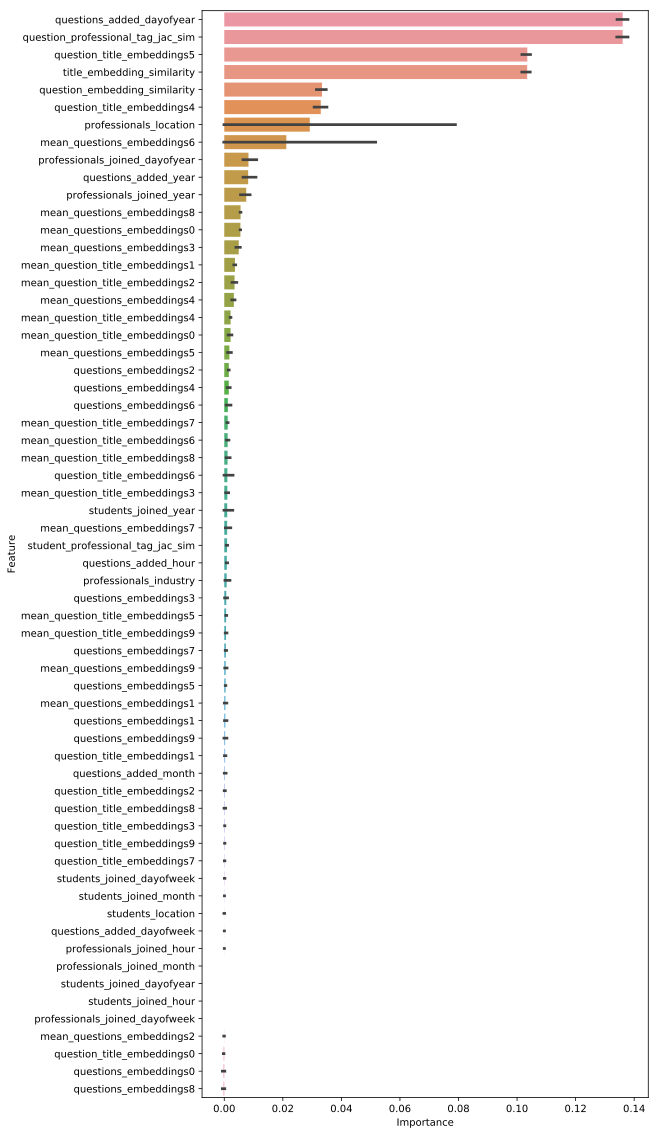

CPU times: user 2h 23min 27s, sys: 1min 51s, total: 2h 25min 18s
Wall time: 2h 21min 48s


In [53]:
%%time

# Compute the cross-validated feature importances
imp_df = permutation_importance_cv(
    X_train, y_train, model, 'auc')

# Plot the feature importances
plt.figure(figsize=(8, 20))
plot_permutation_importance(imp_df)
plt.show()

To actually generate predictions on new data, we would need to first fit our model to data which we've already collected:

In [54]:
# Fit model to historical data
#fit_model = model.fit(X_train, y_train)

Then, after processing data corresponding to new questions as described above (into dataframes `X_new` and `y_new`), we would be able to generate predictions for how likely a professional is to answer each of the new questions:

In [55]:
# Predict answer probability of new questions
#predicted_probs = model.predict(X_new, y_new)

## Conclusion

We've created a processing pipeline which aggregates information across several different data tables, and uses that information to predict how likely a professional is to answer a given question.

How can this predictive model be used to generate a list of questions to recommend to each professional?  Each week, we can generate a list of new questions asked this week (though the time interval doesn't have to be a week - it could be a day, or a month, etc).  This list could also potentially include older questions which have not yet been answered.  Then, for each professional, we can use the recommendation model to generate scores for each new question-professional pair (that is, the probabilities that the professional would answer a given question).  Finally, we could then send the questions with the top K scores (say, the top 10) to that professional.

Another strategy for using the recommendation model would be to recommend *professionals* for each question.  That is, given a question, come up with the top K professionals most likely to answer it, and reccomend the question to them.  This strategy could use the exact same method as described previously (generating a list of new questions, and pairing with each professional), except we would choose the *professionals* with the top K scores for a given question (as opposed to choosing the top K questions for a given professional).  There are pros and cons to this strategy relative to the previous one.  I worry that using this strategy would simply send all the questions to the professionals who answer the most questions (because their answer probabilities are likely to be higher), and not send any questions to professionals who answer fewer questions.  This could result in a small subset of overworked professionals, and the majority of professionals not receiving any recommended questions!  On the other hand, those professionals who answer the most questions are indeed more likely to answer the questions, so perhaps it's OK to send them a larger list of questions.  I think the optimal approach would be to use the first strategy (recommend K questions to each professional), but allow each professional to set their K - that is, let professionals choose how many questions they are recommended per week.

On the other hand, using the current strategy could result in the opposite problem, where only a small subset of questions get sent to professionals.  In the long run, it may be best to view the problem not as a recommendation problem, but as an *allocation* problem.  That is, how can we allocate the questions to professionals such that the expected number of answered questions is highest?  Once we've generated the probabilities that each professional will answer each question, determining the best allocation becomes a discrete optimization problem.  However, the number of elements here is pretty large (questions and professionals).  Deterministic discrete optimization algorithms will likely be impractical (because they'll take too long to run given the large number of elements), and so metaheuristic methods like local search or evolutionary optimization would probably have to be used.

There was a lot of other data provided by CareerVillage which was not used in this model, but which could have been!  Parhaps the most important of this additional data was the data on the scores (basically the "likes") for each answer and question.  Instead of just predicting *whether* a professional was likely to answer a question (as we did with our implicit recommendation system), we could have predicted which questions they were most likely to give a *good* answer to, as judged by the number of "likes" their answers received(an *explicit* recommendation system).

The framework we created here uses a classifier to predict professional-question pairs - basically, a content-based filtering recommendation system.  However, there are other frameworks we could have used.  We could have framed the challenge as an implicit collaborative filtering problem (or even an explicit one if we attempted to predict the "hearts" given to professionals' answers).  I chose not to use a collaborative filtering framework because collaborative filtering suffers from the "cold-start" problem: it has trouble recommending users to new items.  This is because it depends on making predictions about user-item pair scores (in our case, whether professional-question pairs "exist" in the form of an answer) based on similarities between the query user and the scores of the query item by users similar to the query user.  Unfortunately, for this application it is especially important to recommend questions to professionals when the question has no answers yet!  So in production, more often than not there will *be* no scores of the query item by any other users when we want to be making the predictions.  Therefore, we have to use primarily the features about the users and the items to make recommendations.  Although some collaborative filtering methods can take into account the user and item features (such as neural collaborative filtering) I thought it would be best to use a framework which *only* uses the user and item features.